In [1]:
import h5py, numpy as np, os, sys
sys.path.append("..")

from src.utils import _get_synthetic_data
from src.model_zoo import deep_cnn, shallow_cnn
from src.models import ManifoldMixupModel, _Model

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import callbacks as tfkc
from tensorflow_probability import distributions as tfd

from logomaker import Logo
import pandas as pd
import tfomics
from tfomics import impress, evaluate, explain

import inspect 
from inspect import getargspec

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

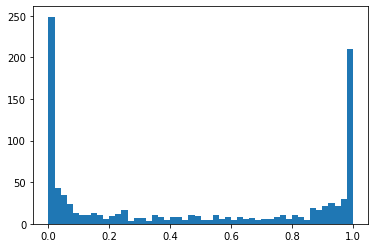

In [10]:
alpha = 0.2
lam = tfd.Beta(alpha, alpha)
xs = lam.sample(1000).numpy()
plt.hist(xs, bins=50);

In [2]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test), model_test = _get_synthetic_data("../data/")

In [22]:
class ManifoldMixupModel(_Model):
    """
    Manifold mixup is a generalization of the input mixup regularization scheme where 
    intermediate layer representations are mixed up rather than just the input layer
    """
    def __init__(self, model, ks, alpha=1.,name="mixup_model"):
        """
        ks -> List of layer activation indices to use for manifold mixup.
        """
        super().__init__(model=model, name=name)
        self.lam_dist = tfd.Beta(alpha, alpha)
        self.ks = ks
    
    def fit(self, *args, **kwargs):
        if not self.run_eagerly:
            print("WARNING: This model can only be run in eager mode.Switching run_eagerly property...")
            self.run_eagerly = False
        return super().fit(*args, **kwargs)

    def train_step(self, data):
        x, y = data
        k = np.random.randint(0, len(self.ks)) ## pick a random layer index
        lam = self.lam_dist.sample()  # sample a mixing coefficient 
        idxs = tf.random.shuffle(tf.range(tf.shape(x)[0])) # shuffled indices 
        xp, yp = tf.gather(x, idxs, axis=0), tf.gather(y, idxs, axis=0) ## shuffled batch
        ym = lam*y + (1-lam)*yp ## mixup the labels

        # record differentiable ops
        with tf.GradientTape() as tape:
            y_pred, ym_pred = x, xp
            for i, layer in enumerate(self.model.layers):
                y_pred = layer(y_pred, training=True)
                ym_pred = layer(ym_pred, training=True)
                if i == k:
                    ym_pred = lam*y_pred + (1-lam)*ym_pred # mixup the representation at the kth layer
            
            # stack the original minibatch to create augmented minibatch and calculate loss
            y_aug = tf.concat([y, ym], axis=0)
            y_pred_aug = tf.concat([y_pred, ym_pred], axis=0)
            loss = self.compiled_loss(y_aug, y_pred_aug, regularization_losses=self.losses)
            print(y_aug.shape, y_pred_aug.shape)

        # Compute gradients and take optimization step
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # finish up
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

In [23]:
model = shallow_cnn.get_model(dropout1=0.1, dropout2=0.5, bn=True)
ks = [0]
for i, layer in enumerate(model.layers):
    if 'activation' in layer.name:
        if layer.activation.__name__ != 'linear':
            ks.append(i)
model = ManifoldMixupModel(model=model, ks=ks, alpha=0.1)

In [24]:
model.compile(
            optimizer=tfk.optimizers.Adam(1e-3), 
            loss=tfk.losses.BinaryCrossentropy(), 
            metrics=[tfk.metrics.AUC(curve='ROC', name='auroc')]
                )

In [25]:
model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=32)

Epoch 1/50
(None, 1) (None, 1)
(None, 1) (None, 1)
438/438 [==============================] - 5s 9ms/step - loss: 0.6346 - auroc: 0.7325 - val_loss: 0.4672 - val_auroc: 0.8651
Epoch 2/50
438/438 [==============================] - 4s 9ms/step - loss: 0.4731 - auroc: 0.8700 - val_loss: 0.3981 - val_auroc: 0.9058
Epoch 3/50
438/438 [==============================] - 4s 9ms/step - loss: 0.4165 - auroc: 0.9040 - val_loss: 0.3676 - val_auroc: 0.9210
Epoch 4/50
438/438 [==============================] - 4s 9ms/step - loss: 0.3851 - auroc: 0.9217 - val_loss: 0.4370 - val_auroc: 0.9301
Epoch 5/50
438/438 [==============================] - 4s 9ms/step - loss: 0.3706 - auroc: 0.9318 - val_loss: 0.3703 - val_auroc: 0.9366
Epoch 6/50
438/438 [==============================] - 4s 9ms/step - loss: 0.3499 - auroc: 0.9391 - val_loss: 0.3289 - val_auroc: 0.9391
Epoch 7/50
438/438 [==============================] - 4s 9ms/step - loss: 0.3390 - auroc: 0.9442 - val_loss: 0.3294 - val_auroc: 0.9426
Epoch 8/

In [29]:
# test model 
model.evaluate(x_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.2791 - auroc: 0.9634


[0.2791157364845276, 0.9633976221084595]

In [30]:
# get positive label sequences and sequence model
pos_index = np.where(y_test[:,0] == 1)[0]   

num_analyze = len(pos_index)
X = x_test[pos_index[:num_analyze]]
X_model = model_test[pos_index[:num_analyze]]

# instantiate explainer class
explainer = tfomics.explain.Explainer(model, class_index=0)

# calculate attribution maps
#mutagenesis_scores = explainer.mutagenesis(X, class_index=None)
saliency_scores = explainer.saliency_maps(X)
smoothgrad_scores = explainer.smoothgrad(X, num_samples=50, mean=0.0, stddev=0.1)
#intgrad_scores = explainer.integrated_grad(X, baseline_type='zeros')
#expintgrad_scores = explainer.expected_integrated_grad(X, num_baseline=50, baseline_type='random')

# reduce attribution maps to 1D scores
#mut_scores = tfomics.explain.l2_norm(mutagenesis_scores)
sal_scores = tfomics.explain.grad_times_input(X, saliency_scores)
sg_scores = tfomics.explain.grad_times_input(X, smoothgrad_scores)
#int_scores = tfomics.explain.grad_times_input(X, intgrad_scores)
#expint_scores = tfomics.explain.grad_times_input(X, expintgrad_scores)

In [31]:
# compare distribution of attribution scores at positions with and without motifs
threshold = 0.1
#mutagenesis_roc, mutagenesis_pr = tfomics.evaluate.interpretability_performance(mut_scores, X_model, threshold)
saliency_roc, saliency_pr = tfomics.evaluate.interpretability_performance(sal_scores, X_model, threshold)
smoothgrad_roc, smoothgrad_pr = tfomics.evaluate.interpretability_performance(sg_scores, X_model, threshold)
#intgrad_roc, intgrad_pr = tfomics.evaluate.interpretability_performance(int_scores, X_model, threshold)
#expintgrad_roc, expintgrad_pr = tfomics.evaluate.interpretability_performance(expint_scores, X_model, threshold)

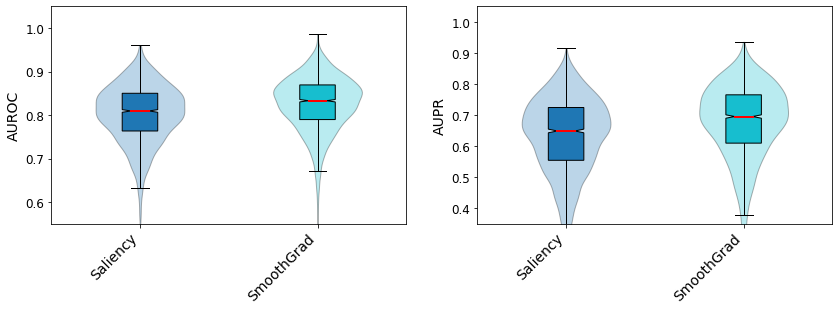

In [34]:
scores = [saliency_roc, smoothgrad_roc]
names = ['Saliency', 'SmoothGrad', ]

fig = plt.figure(figsize=(14,4))  
ax = plt.subplot(1,2,1)
ax = tfomics.impress.box_violin_plot(scores, ylabel='AUROC', xlabel=names)
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
ax.set_ybound([.55,1.05])
#ax.tick_params(labelbottom=False) 

scores = [saliency_pr, smoothgrad_pr, ]
ax = plt.subplot(1,2,2)
ax = tfomics.impress.box_violin_plot(scores, ylabel='AUPR', xlabel=names)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
ax.set_ybound([.35,1.05])
#ax.tick_params(labelbottom=False) 

In [ ]:
a, b, c = np.random.randn(2), np.random.randn(2), np.random.randn(2)
f = h5py.File("test.h5", 'w')
f.create_group('g1')
f['g1'].create_dataset(name='a', data=a)
f.create_group('g2')
f['g2'].create_dataset(name='b', data=b)
f['g2'].create_dataset(name='c', data=c)
f.close()

f = h5py.File("test.h5", 'r')
groups = f.keys()
print(groups)
for group in groups:
    for key in f[group].keys():
        print(f[group][key].name, f[group][key][:])
f.close()
!rm test.h5

In [ ]:
print(a, b, c)

In [ ]:
format(l2, ".0e")

In [ ]:
data = np.eye(4)[np.random.randint(0,4,(20,))].astype(np.int32)
seq = pd.DataFrame(data=data, columns=list('ACGT'))

In [ ]:
Logo(seq)

In [ ]:
seq = pd.DataFrame(data=data[::-1, ::-1], columns=list('ACGT'))
Logo(seq)

In [ ]:
Logo(
    pd.DataFrame(data=data[::-1,:][:,::-1], columns=list('ACGT'))
)

In [ ]:
class EarlyStoppingCheckpoint(tfkc.EarlyStopping):
    """
    This callback checkpoints the model at the early stopping epoch 
    without actually stopping. We can use this to put a marker on 
    the exact epoch where model training would have stoppedm *without* 
    actually stopping. 
    
    This callback takes the same arguments as the keras.callbacks.EarlyStopping
    callback. 
    
    Documentation for the EarlyStopping callback follows.
    ------------------------------------------------------
    
    """
    __doc__  = __doc__ + tfkc.EarlyStopping.__doc__
    
    def on_epoch_end(self, epoch, logs=None):
        if self.stopped_epoch > 0:  ## the early stopping epoch has already been logged 
            return
        else:
            current = self.get_monitor_value(logs) ## get current value of monitored value. 
            if current is None:  ## the requested monitor quantity is not in the logs
                return
            
            self.wait += 1
            if self._is_improvement(current, self.best):
                ## update the best seen value of the monitored metric.
                self.best = current
                
                # get the best weights of the model 
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()
            
            # Only restart wait if we beat both the baseline and our previous best.
            if self.baseline is None or self._is_improvement(current, self.baseline):
                self.wait = 0
        
            # check to see if we have waited long enough ; if true, this is where the training would have stopped
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.restore_best_weights and self.best_weights is not None:
                    # checkpoint the model 
                    self.model.save("early_stopping_ckpt")
                    
                    if self.verbose:
                        print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
                        print('The best model weights from early stopping are checkpointed as - early_stopping_ckpt')

In [ ]:
# get data 
datadir = os.path.abspath("../data/")
traindata, validdata, testdata, model_test = _get_synthetic_data(datadir)

# set up model
model = get_model(bn=True, dropout1=0.2, dropout2=0.5)

# compile model
model.compile(
            loss=tfk.losses.BinaryCrossentropy(), 
            optimizer=tfk.optimizers.Adam(1e-3),
            metrics=[tfk.metrics.AUC(curve='PR', name='aupr'), tfk.metrics.AUC(curve='ROC', name='auroc')]
)

# fit model
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
                                        monitor='val_auroc',
                                        factor=0.2,
                                        patience=4,
                                        min_lr=1e-7,
                                        mode='max',
                                        verbose=1
                                            )
esckpt_callback = EarlyStoppingCheckpoint(
                                    monitor='val_auroc',
                                    patience=4,
                                    verbose=1,
                                    mode='max',
                                    restore_best_weights=True
                                        )
callbacks = [reduce_lr, esckpt_callback]
traindata = tf.data.Dataset.from_tensor_slices(traindata)
validdata = tf.data.Dataset.from_tensor_slices(validdata)
model.fit(
        traindata.shuffle(10000).batch(32), 
        validation_data=validdata.shuffle(10000).batch(64),
        epochs=100,
        callbacks=callbacks
        )

In [ ]:
help(esckpt_callback)

In [ ]:
file = h5py.File("data.h5", "w",)
file.create_dataset(name='x', data=x, compression='gzip')
file.create_dataset(name='y', data=y, compression='gzip')
file.close()
del file

In [ ]:
file = h5py.File("data.h5", "r")
print(file.keys())
print(file['x'].shape)
print(file['y'].shape)
print(file['x'][:])
print(file['y'][:])
file.close()

In [ ]:
help(file.create_dataset)

In [ ]:
# file = open("commands.txt", "w")
# for l2 in ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6']:
#     for factor in ['1', '4', '8']:
#         for type in ['deep', 'shallow']:
#             file.write(f"python task1_sub5_1_train.py --batch 32 --epochs 100 --start_trial 1 --end_trial 5 --lr 1e-3 --track_saliency --track_sg --track_intgrad --factor {factor} --type {type} --l2 {l2} \n")
# for d1 in ['0.1', '0.2', '0.3', '0.5', '0.75']:
#     for factor in ['1', '4', '8']:
#         for type in ['deep', 'shallow']:
#             file.write(f"python task1_sub5_2_train.py --batch 32 --epochs 100 --start_trial 1 --end_trial 5 --lr 1e-3 --track_saliency --track_sg --track_intgrad --factor {factor} --type {type} --dropout1 {d1} \n")
# file.close()